# Introductory Tutorial: Estimating and Minimizing LCOE

In this demo analysis, we will analyze the `Ard` layout-to-LCOE stack for land-based analysis.
First, `Ard` must be installed, and the unit and system tests must be able to run correctly.
If the unit and system testing suite runs correctly, the example here should be guaranteed to run correctly; see `test/README.md`.

Assuming these are done and `Ard` has been installed cleanly, you should be able to run an LCOE optimization problem in this directory by typing
```shell
python optimization_demo.py
```
at the command line with the current working directory set to that which holds this file.
The result is that an output directory `optimization_demo_out` should be created, and a directory `case_files` holding configuration files that allow repeatable single-discipline analyses.

In the next section, we will detail what the optimization case in `optimization_demo.py` does.

## Optimization code description

In `optimization_demo.py`, we built out a demonstration of totally stock onshore `Ard` run.
We configure the `Ard` "system" in the file `inputs/ard_system.yaml`.
For `Ard` a system refers to the set of disciplinary analyses to be run in an analysis or optimization problem.
So, in this file, we:
1. specify an Ard onshore preset system using: `system: "onshore"`, consisting of:
    1. a finite-differencable layout-to-AEP group:
       1. a layout component to map from orientation angle, primary and perpendicular spacing, and skew angle parameters (4 total) to $(x,y)$ locations for 25 turbines
       2. a FLORIS AEP component to compute AEP given the turbines and layout
    2. a land use component to map from the parameterized layout (or a raw layout) to a measure of the land used by the farm
    3. a detailed collection system design component: DTU's `optiwindnet`
    4. a turbine spacing constraint component
    5. a WISDEM-based turbine capital costs component
    6. a component for BOS estimation using LandBOSSE
    7. a WISDEM-based operating and maintenance component
    8. a WISDEM-based plant finance integration component
    - this default system (and some alternative options) can be found at `ard/api/default_systems/ard_system_onshore.yaml`
2. configure the modeling options for the problem at hand
    - farm specifications
    - a wind dataset to use: `wrg_example.wrg`, [which is borrowed directly form the FLORIS dataset](https://github.com/NREL/floris/blob/fd0e599ef01dc9f1d426d2b4c99e2f6beb57fefd/examples/examples_wind_resource_grid/wrg_example.wrg)
    - a wind turbine specification to use, for now via a specialized `Ard` input file, which generalizes the collective of variables that will define the design and costs of a wind turbine, across various tools
    - collection system solver details
    - floating/offshore flags
3. specify the analysis that we want to perform
    - for now, an COBYLA gradient-free optimization using the Scipy driver from OpenMDAO
    - on the four parametric layout design variables
    - subject to constraints on turbine spacing (minimum 3 rotor diameter spacing)
    - optimizing for the minimum LCOE
This analysis is specified in the yaml file and input in line 15 of `optimization_demo.py`.
The next call, sets up the model and creates an OpenMDAO "problem" to solve.
Flipping the flag to `True` in line 20 will turn on [an OpenMDAO tool called N2 Diagrams](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_details/n2_details.html), which allows the analysis system to be vizualized!

From here, we run a single top-down analysis run, as in line 25, for the configuration declared in the system yaml file.
The results will be printed to the command line, including the key outcomes in the problem.

Next, if `optimize` is set to `True` in line 47, a short optimization problem will run, to solve the problem set up in the system yaml file.
Again, the results of this optimization will be printed to the screen but additionally the output of the optimization will be written to a driver for analysis here.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import openmdao.api as om

# use a dark background for plotting
plt.style.use(["dark_background"])

In [2]:
# load the results

# get the case data from the OpenMDAO optimization
cr = om.CaseReader(Path.cwd() / "optimization_demo_out" / "cases.sql")
driver_cases = cr.list_cases("driver", out_stream=None)

# extract the relevant optimization variables
objective_values = {}
constraint_values = {}
design_variables = {}

# initialize all the data variables
case_init = cr.get_case(driver_cases[0])
for k_obj in case_init.get_objectives().keys():
    objective_values[k_obj] = []
for k_cons in case_init.get_constraints().keys():
    constraint_values[k_cons] = []
for k_DV in case_init.get_design_vars().keys():
    design_variables[k_DV] = []

# then populate them
for case in [cr.get_case(v) for v in driver_cases]:
    for k_obj, v_obj in case.get_objectives().items():
        objective_values[k_obj].append(np.array(v_obj))
    for k_cons, v_cons in case.get_constraints().items():
        constraint_values[k_cons].append(np.array(v_cons))
    for k_DV, v_DV in case.get_design_vars().items():
        design_variables[k_DV].append(np.array(v_DV))

# create some pretty variable names:
title_map = {
    "financese.lcoe": "levelized cost of energy, $\\mathrm{LCOE}^{(i)}$ (\\$/kWh)",
    "turbine_spacing": "turbine spacing constraint values (m)",
    "spacing_primary": "primary axis spacing ($D_{\\mathrm{rotor}}$)",
    "spacing_secondary": "secondary axis spacing ($D_{\\mathrm{rotor}}$)",
    "angle_orientation": "orientation angle (degrees)",
    "angle_skew": "skew angle (degrees)",
}

## Analysis

Given the result of the last iteration analysis, we can now explore how the optimization arrived at it.
In the next few sections, we show the path of the optimizer.

### Objective function

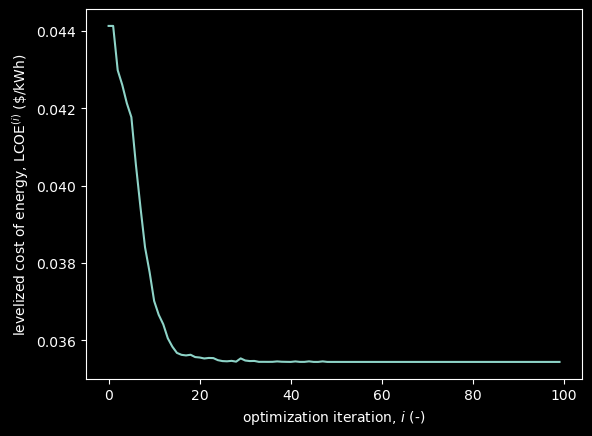

In [3]:
# plot the objective function of the optimization problem
fig, ax = plt.subplots()
for name_obj, values_obj in objective_values.items():
    ax.plot(values_obj, label=title_map[name_obj])
ax.set_xlabel("optimization iteration, $i$ (-)")
ax.set_ylabel(title_map[name_obj])
plt.show()

### Constraints

There are actually no constraints on this problem so the next block won't output anything...

turbine_spacing


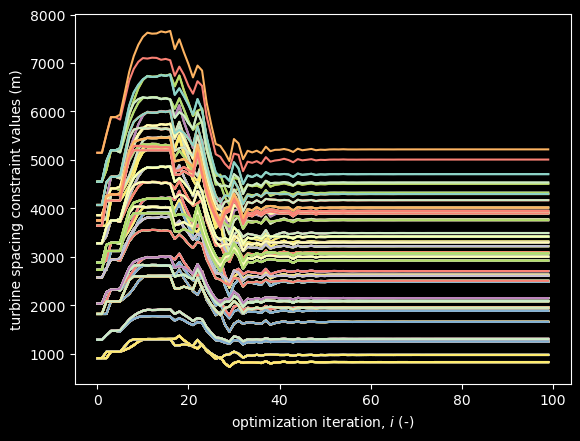

In [4]:
# plot the constraint function of the optimization problem
if constraint_values.keys():
    fig, axes = plt.subplots(
        len(constraint_values.keys()), 1, sharex=True, squeeze=False
    )
    for idx_cons, (name_cons, values_cons) in enumerate(constraint_values.items()):
        print(name_cons)
        axes[idx_cons, 0].plot(values_cons, label=name_cons)
        axes[idx_cons, 0].set_ylabel(title_map[name_cons])
    axes[-1, 0].set_xlabel("optimization iteration, $i$ (-)")
plt.show()

### Design variables

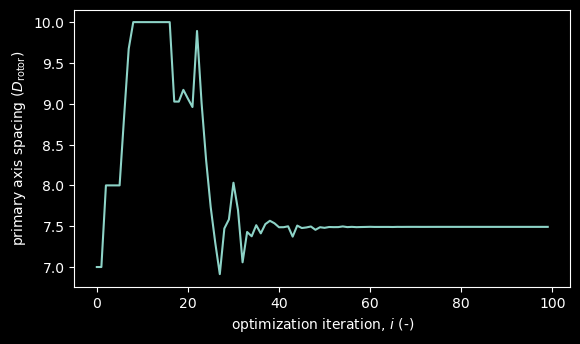

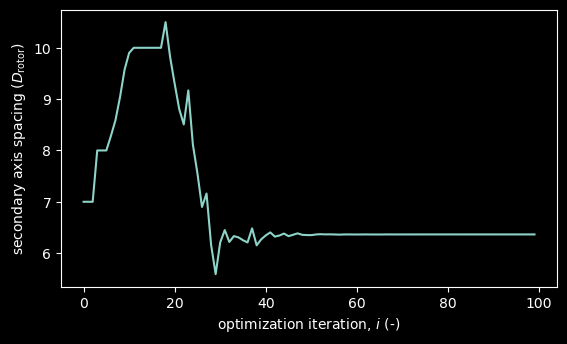

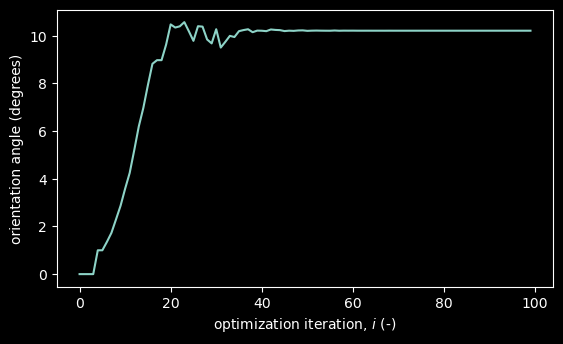

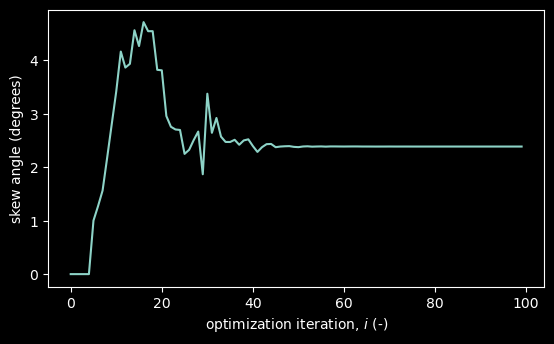

In [5]:
# plot the design variables of the optimization problem
for idx_DV, (name_DV, values_DV) in enumerate(design_variables.items()):
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(values_DV, label=name_DV)
    ax.set_xlabel("optimization iteration, $i$ (-)")
    ax.set_ylabel(title_map[name_DV])
plt.show()

## Conclusion

These results show that the optimization, after about 25 iterations delivers around 8¢/kWh of savings.
These are realized by orienting the farm, slightly skewing it, and adjusting its spacing.